**Contact:** Corentin Ravoux (CPPM) : corentin.ravoux.research@gmail.com

--------

# Mount Drive and Collect data

--------


**Before starting, click on [this folder](https://drive.google.com/drive/folders/1FRNzxto4hvF91aa5wnyRccZ7HgXAoBNZ?usp=sharing) and create a shortcut to your google drive by following these steps:**

*   In the top, click on the arrow next to the name of the folder "Lyman alpha MACSS 2023"
*   Click Create Shortcut in Drive
*   Choose My Drive (in "All" tab)

**In the folder "One-dimensional power spectrum/tutorial", right click on the notebook (.ipynb) you are working on and create a copy in your drive (not a shortcut)**

**Alternative:** This notebook can be downloaded along with the associated data to work on your laptop. Change the path_to_data accordingly.

In [ ]:
# Define the path where the data are stored
from google.colab import drive
drive.mount('/content/drive')
path_to_data="/content/drive/My Drive/Lyman alpha MACSS 2023/One-dimensional power spectrum/tutorial/data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install the packages we need
%%capture
!pip install fitsio

In [ ]:
# Import the packages we need

import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(os.path.join(path_to_data,"style.mplstyle"))
import pandas as pd
import fitsio
from numpy.fft import rfft, rfftfreq

In [ ]:
# Some usefull function given to you, totally free.

def return_dataframe(
    catalog_name,
    extname="QSO_CAT",
    colname_drop=None,
    return_unique=False,
):
    if colname_drop is not None:
        f = fitsio.FITS(catalog_name)[extname].read().byteswap().newbyteorder()
        dtype_new = []
        for i in range(len(f.dtype.names)):
            if f.dtype.names[i] not in colname_drop:
                dtype_new.append((f.dtype.names[i], f.dtype[f.dtype.names[i]]))
        new_f = np.zeros(f.shape[0], dtype=dtype_new)
        for i in range(len(dtype_new)):
            new_f[dtype_new[i][0]] = f[dtype_new[i][0]]
        df = pd.DataFrame(new_f)
    else:
        df = pd.DataFrame(
            fitsio.FITS(catalog_name)[extname].read().byteswap().newbyteorder()
        )
    if return_unique:
        _, idx = np.unique(df["TARGETID"], return_index=True)
        sel = np.zeros(df["TARGETID"].size, dtype="bool")
        sel[idx] = True
        return df[sel]
    else:
        return df



--------

# One dimensional power spectrum with Lyman-α forests from DESI (Dark Energy Spectroscopic Instrument):

--------


###**In this tutorial, we will try to understand the Lyman-alpha forest coming from DESI, and try to reproduce the One-dimensional power spectrum with those data. More details in https://arxiv.org/abs/2306.06311**

### **The parts of this tutorial are independent. You can move on if you are stuck**



## 1. What is a Lyman-alpha forest (5 min):

DESI is a multi-object spectrograph conducting a five-year survey that measures the spectra of galaxies and quasars.

Here, we are interested in observing quasars (supermassive black hole + accretion disk) which are among the brightest known objects of our Universe (100 times the Milky Way). As they are very bright, they can be seen very far, and consequently very early in the past (up to 12 billion years ago).

We will use the spectra of quasars with a redshift higher than 2.0, for which we can observe from the ground the Lyman-alpha emission line (121.567 nm). The quasar is so far that the light it emits in the UV is optic for us.

Near the Lyman-alpha emission line, a series of Lyman-alpha absorption features, called **Lyman-alpha forest**, corresponds to absorption by the matter between the quasar and us. In https://www.pontzen.co.uk/media/dla_credited.mov, you can see an example of the formation of a forest.


## 2. Quasar catalog (30 min):

In this tutorial, we will work on the first DESI data release, Early Data Release. This data set contains the observations used to test the quality of the instrument. We are interested here in the quasar spectra of this data release.

A quasar (or QSO) enters into the classification of Active Galaxy Nucleus (AGN). A scientific representation of this object is given [here](https://zenodo.org/record/6381013).

To observe the Lyman-alpha forest, we use them as a backlight source. However, to properly define the forests we will observe, we need to list the quasars observed in a catalog.



Let us first open the quasar catalog of EDR with pandas.

Pandas is a python library optimized for data analysis and has started to be widely used. From the quasar catalog, it creates a frame of data.

In [ ]:
colname_drop = ["FMIN_SIIV_450",
"POSMIN_SIIV_450",
"VMAX_SIIV_450",
"VMIN_SIIV_450",
"FMIN_SIIV_2000",
"POSMIN_SIIV_2000",
"VMAX_SIIV_2000",
"VMIN_SIIV_2000",
"FMIN_CIV_450",
"POSMIN_CIV_450",
"VMAX_CIV_450",
"VMIN_CIV_450",
"FMIN_CIV_2000",
"POSMIN_CIV_2000",
"VMAX_CIV_2000",
"VMIN_CIV_2000",
"PCA_COEFFS"]
qso_catalog = return_dataframe(
    os.path.join(path_to_data,"qso_catalog_sv13.fits"),
    extname="ZCATALOG",
    colname_drop=colname_drop,
)

qso_catalog
qso_catalog[qso_catalog["SURVEY"] == "sv1"].shape, qso_catalog[qso_catalog["SURVEY"] == "sv3"].shape,

((31591, 81), (37159, 81))

Ok, it contains a lot of information.

To see the name of all the columns, execute the following:



In [ ]:
qso_catalog.columns

Index(['TARGETID', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'COADD_FIBERSTATUS',
       'TARGET_RA', 'TARGET_DEC', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R',
       'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R',
       'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'MW_TRANSMISSION_G',
       'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1',
       'MW_TRANSMISSION_W2', 'PROBA_RF', 'MASKBITS', 'SV1_DESI_TARGET',
       'SV1_SCND_TARGET', 'DESI_TARGET', 'COADD_NUMEXP', 'COADD_EXPTIME',
       'CMX_TARGET', 'SV2_DESI_TARGET', 'SV3_DESI_TARGET', 'SV2_SCND_TARGET',
       'SV3_SCND_TARGET', 'SCND_TARGET', 'TSNR2_LYA', 'TSNR2_QSO',
       'DELTA_CHI2_MGII', 'A_MGII', 'SIGMA_MGII', 'B_MGII', 'VAR_A_MGII',
       'VAR_SIGMA_MGII', 'VAR_B_MGII', 'Z_RR', 'Z_QN', 'C_LYA', 'C_CIV',
       'C_CIII', 'C_MgII', 'C_Hbeta', 'C_Halpha', 'Z_LYA', 'Z_CIV', 'Z_CIII',
       'Z_MgII', 'Z_Hbeta', 'Z_Halpha', 'QSO_MASKBITS', 'HPXPIXEL', 'SURVEY',
       'PROGRAM', 'LASTNIGHT', 'PCA_CHI2', 

We will start by cleaning the catalog, which will help us learn to use masks in numpy/pandas.

The following creates a mask that only selects the quasar (QSO) objects. Applying the mask to a numpy array or a pandas frame returns only the quasars.

In [ ]:
mask = qso_catalog['SPECTYPE'] == 'QSO'
qso_catalog = qso_catalog[mask]
qso_catalog

,TARGETID,Z,ZERR,ZWARN,SPECTYPE,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,MORPHTYPE,EBV,...,AI_CIV,ERR_AI_CIV,NCIV_450,BI_SIIV,ERR_BI_SIIV,NSIIV_2000,AI_SIIV,ERR_AI_SIIV,NSIIV_450,BALMASK
1,39628368194307737,1.292904,0.000080,0,QSO,0,197.122649,24.677198,PSF,0.021188,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,5
2,39628357184262231,0.813544,0.000016,0,QSO,0,197.203801,24.350770,PSF,0.017858,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,5
3,39628362695576550,0.942213,0.000087,0,QSO,0,197.148291,24.568655,PSF,0.017821,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,5
4,39628368190116444,1.640907,0.000219,0,QSO,0,197.001098,24.660327,PSF,0.018185,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0
5,39628362695576213,1.257580,0.000156,0,QSO,0,197.133405,24.607848,PSF,0.018701,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68745,39633154079723233,1.085287,0.000130,0,QSO,0,247.849489,44.219850,PSF,0.008831,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,5
68746,39633158404050749,0.831060,0.000158,0,QSO,0,247.760592,44.435361,PSF,0.009721,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,5
68747,39633154083913926,1.902029,0.000981,0,QSO,0,247.901376,44.228754,PSF,0.009105,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0
68748,39633154079723272,3.923634,0.000389,0,QSO,0,247.852596,44.285166,PSF,0.009317,...,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0


---
**Your turn**

---


Similarly, select the quasars whose redshifts are higher than 2.1.

Hint: redshift is given by 'Z' in the frame.

In [ ]:
# Select quasars with redshift higher than 2.1

mask = qso_catalog['Z'] > 2.1
qso_catalog = qso_catalog[mask]
qso_catalog

,TARGETID,Z,ZERR,ZWARN,SPECTYPE,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,MORPHTYPE,EBV,...,AI_CIV,ERR_AI_CIV,NCIV_450,BI_SIIV,ERR_BI_SIIV,NSIIV_2000,AI_SIIV,ERR_AI_SIIV,NSIIV_450,BALMASK
6,39628362695576436,2.841623,0.000329,0,QSO,0,197.143901,24.520984,PSF,0.017358,...,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0
9,39628368198500958,2.873768,0.000396,0,QSO,0,197.354304,24.708547,PSF,0.016604,...,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0
10,39628368194309846,2.317624,0.000046,0,QSO,0,197.242688,24.630838,PSF,0.016783,...,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0
12,39628368194309407,2.126186,0.000075,0,QSO,0,197.220318,24.729864,PSF,0.019381,...,0.000000,0.000000,0,0.000000,0.000000,0,0.000000,0.000000,0,0
17,39628362699768732,2.362916,0.000114,0,QSO,0,197.342485,24.600798,PSF,0.016564,...,707.564209,6.010602,2,0.000000,0.000000,0,19.378439,3.328213,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68730,39633145363956665,2.369855,0.000193,0,QSO,0,247.317145,43.813767,PSF,0.008561,...,130.226593,2.093551,1,0.000000,0.000000,0,0.000000,0.000000,0,0
68732,39633145359764770,2.225666,0.000239,0,QSO,0,247.157037,43.852210,PSF,0.007622,...,0.000000,0.000000,0,82.103622,5.802943,1,3003.419434,35.196041,4,0
68737,39633145359762168,2.620823,0.000148,0,QSO,0,246.965280,43.783736,PSF,0.006461,...,302.707336,2.380034,1,0.000000,0.000000,0,0.000000,0.000000,0,0
68740,39633140972521559,2.665972,0.000079,0,QSO,0,246.779519,43.441567,PSF,0.009013,...,111.941307,1.951534,1,0.000000,0.000000,0,0.000000,0.000000,0,0


In this catalog, we are interested in the redshift and the position on the sky of the quasars.

The position on the sky is given in the equatorial coordinate system (Angle in the earth frame [more details here](https://en.wikipedia.org/wiki/Equatorial_coordinate_system)), and called right ascension RA and declination DEC.

In the pandas frame, the corresponding columns are 'TARGET_RA' and 'TARGET_DEC'.

---
**Your turn**

---

Plot the quasar's position on the sky (RA as a function of DEC). You can use the scatter function of matplotlib (cf. google).

Bonus: There are two kinds of survey in the first DESI data, "sv1" and "sv3". Plot separately the two surveys ('SURVEY' in the pandas frame)

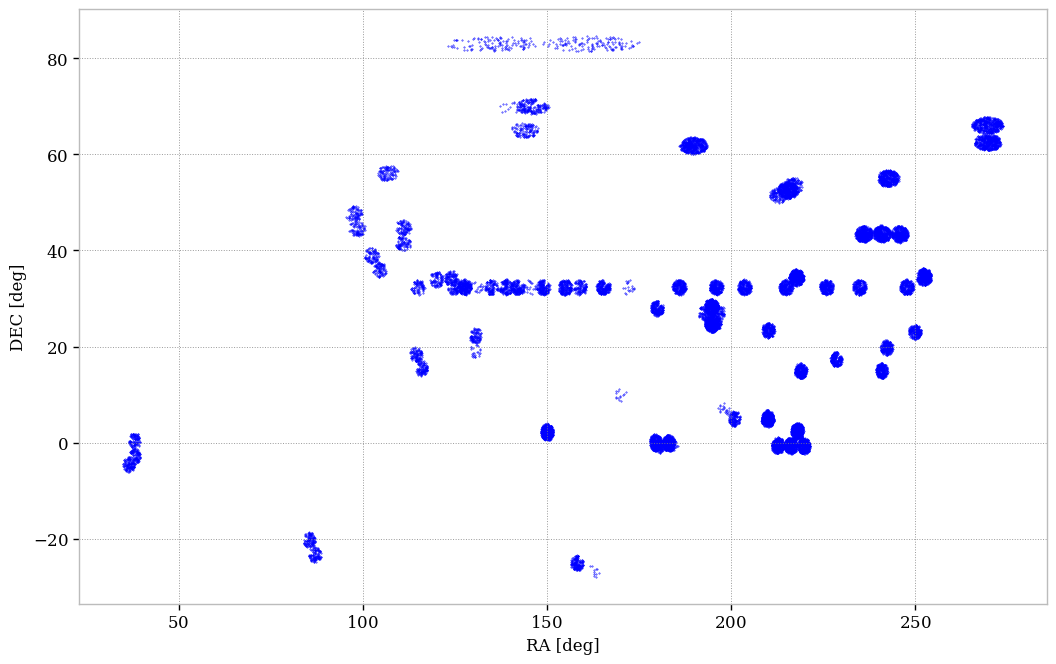

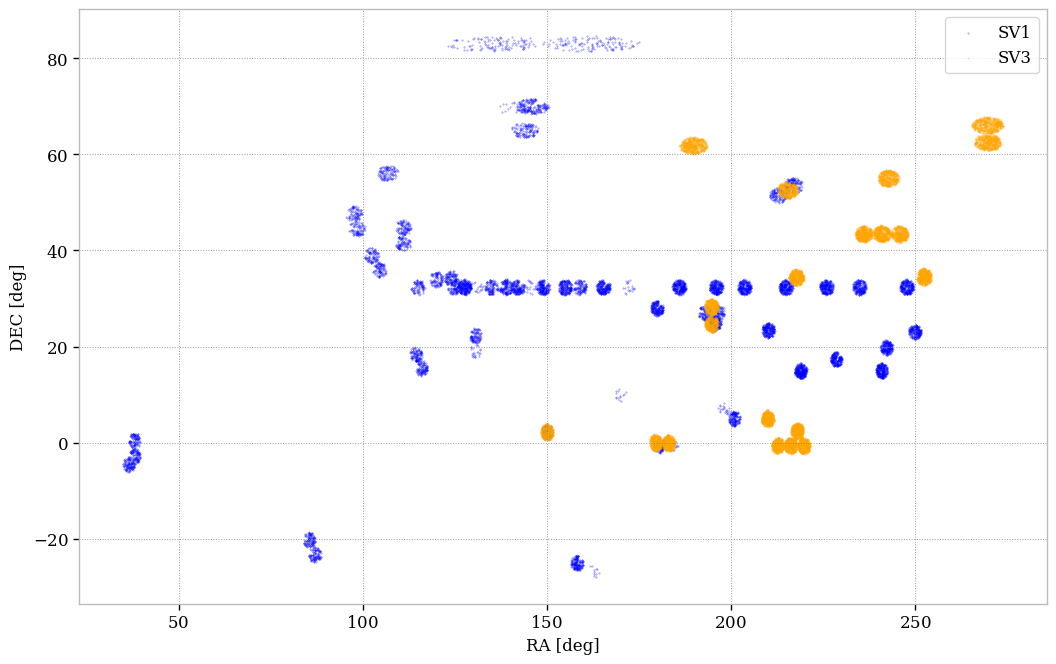

In [ ]:
# Plot the position of the quasars on the sky

plt.scatter(qso_catalog['TARGET_RA'],qso_catalog['TARGET_DEC'], marker = '.', s = 0.5)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

# Bonus: separate sv1 and sv3

mask_sv1 = qso_catalog['SURVEY'] == "sv1"
mask_sv3 = qso_catalog['SURVEY'] == "sv3"

plt.figure()

plt.scatter(qso_catalog['TARGET_RA'][mask_sv1],qso_catalog['TARGET_DEC'][mask_sv1],color="C0", alpha = 0.5, marker = '.', s = 0.5)
plt.scatter(qso_catalog['TARGET_RA'][mask_sv3],qso_catalog['TARGET_DEC'][mask_sv3],color="C1", alpha = 0.5, marker = '.', s = 0.5)
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')
plt.legend(["SV1","SV3"])

The observed quasars of those first data are very sparse. It is expected as we wanted to test the performance of the DESI instrument in various.

---
**Your turn**

---

Plot the histogram of quasar redshifts (function hist in matplotlib --> google is still your friend).

Bonus: Separate sv1 and sv3 surveys

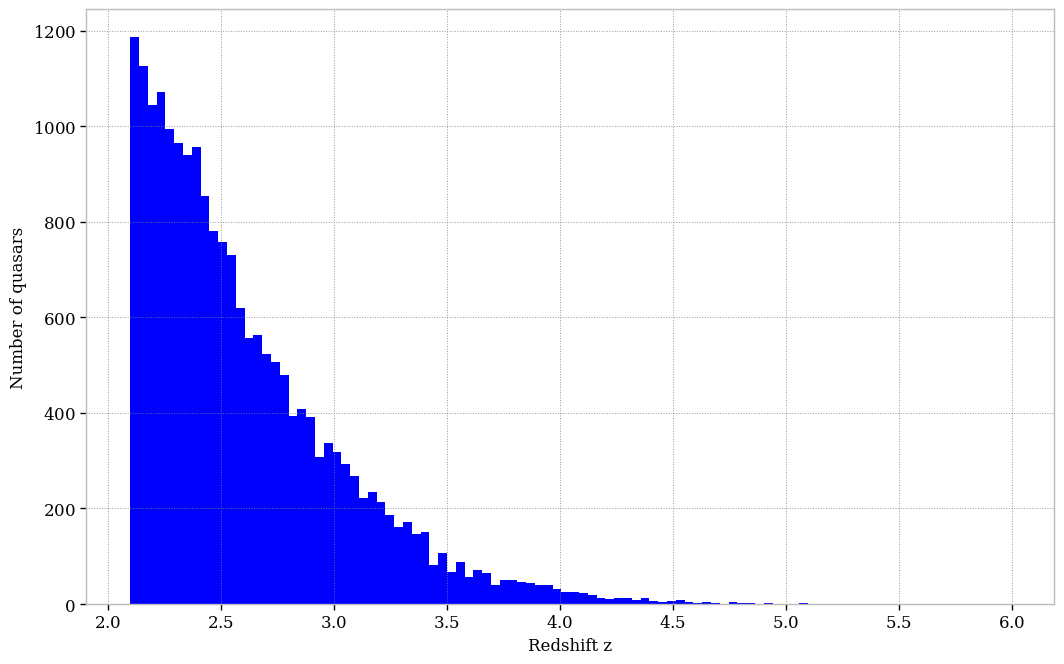

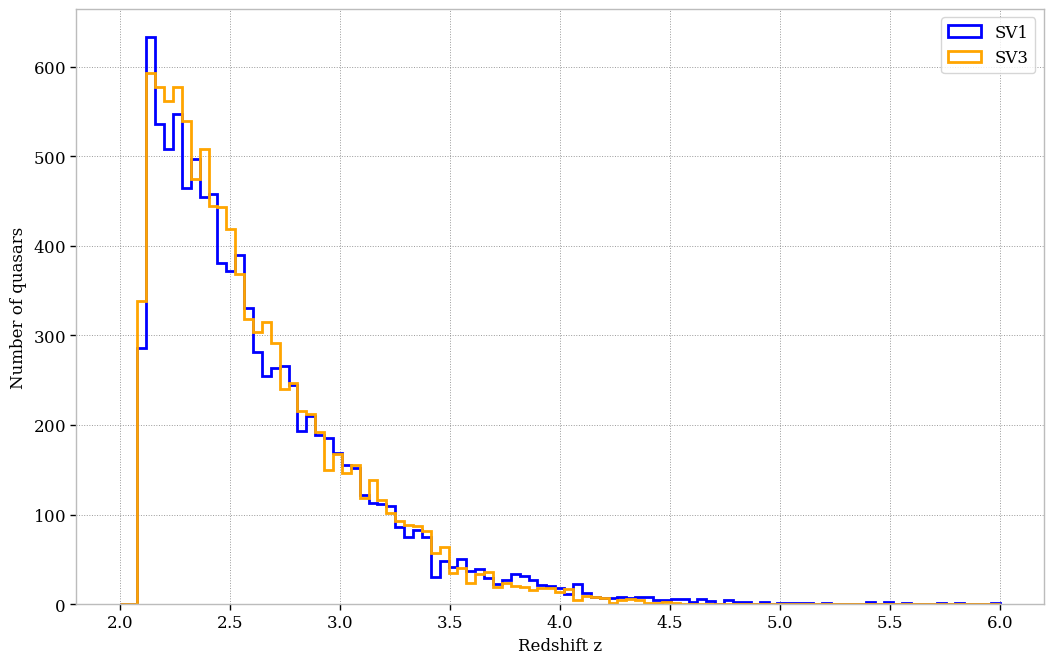

In [ ]:
# Plot the histogram of quasar redshifts

plt.hist(qso_catalog['Z'],100)
plt.xlabel("Redshift z")
plt.ylabel("Number of quasars")


# Bonus: separate sv1 and sv3

mask_sv1 = qso_catalog['SURVEY'] == "sv1"
mask_sv3 = qso_catalog['SURVEY'] == "sv3"

plt.figure()

bins = np.linspace(2.0,6.0,100)
plt.hist(qso_catalog['Z'][mask_sv1],bins,alpha=1,edgecolor="C0", histtype = 'step', fill = None, linewidth=2)
plt.hist(qso_catalog['Z'][mask_sv3],bins,alpha=1,edgecolor="C1", histtype = 'step', fill = None, linewidth=2)
plt.xlabel("Redshift z")
plt.ylabel("Number of quasars")
plt.legend(["SV1","SV3"])


The DESI instrument observed the quasars for a certain amount of time. We calculated an effective exposure time from the actual exposure time and the atmospheric conditions (seeing, airmass, transparency, throughput...).

This effective time can be computed the following way (trust me):

In [ ]:
teff_lya = 11.80090901380597 * qso_catalog["TSNR2_LYA"]

---
**Your turn**

---

Plot the histogram of effective time.

Bonus: Separate sv1 and sv3 surveys

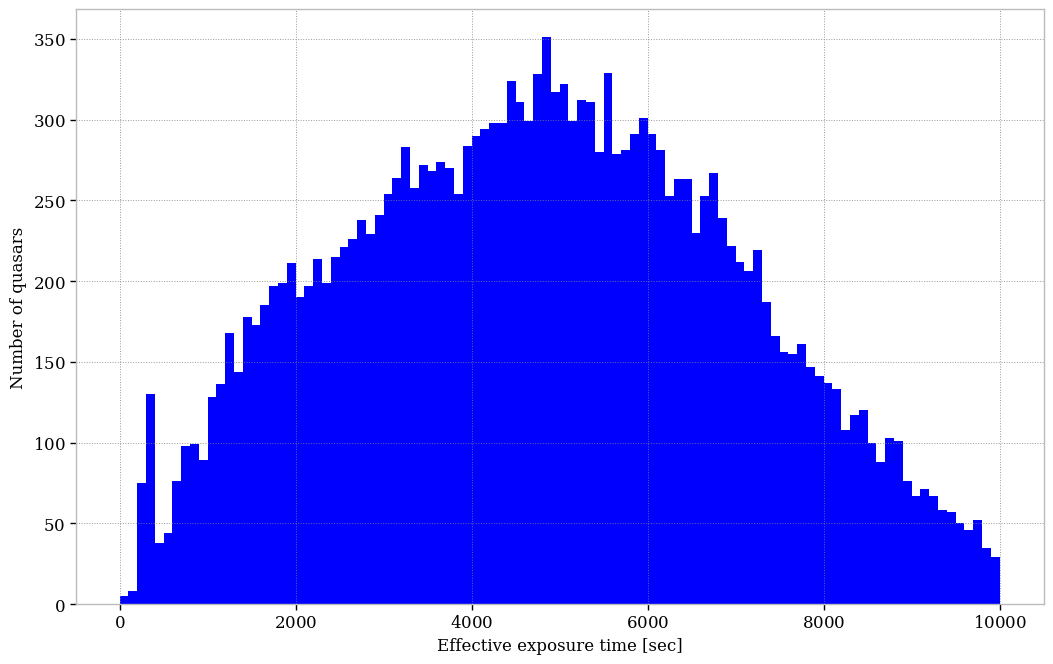

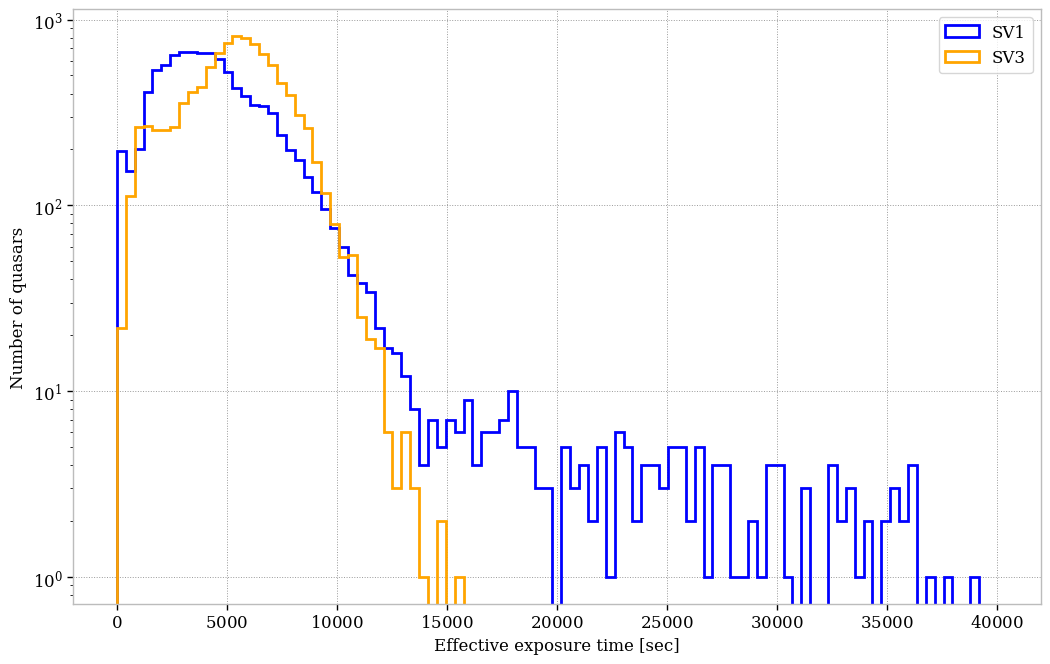

In [ ]:
# Plot the histogram of quasar redshifts

plt.hist(teff_lya,100,range=(0,10000))
plt.xlabel("Effective exposure time [sec]")
plt.ylabel("Number of quasars")


# Bonus: separate sv1 and sv3

mask_sv1 = qso_catalog['SURVEY'] == "sv1"
mask_sv3 = qso_catalog['SURVEY'] == "sv3"

plt.figure()

bins = np.linspace(0,40000,100)
plt.hist(teff_lya[mask_sv1],bins,alpha=1,edgecolor="C0", histtype = 'step', fill = None, linewidth=2)
plt.hist(teff_lya[mask_sv3],bins,alpha=1,edgecolor="C1", histtype = 'step', fill = None, linewidth=2)
plt.yscale("log")
plt.xlabel("Effective exposure time [sec]")
plt.ylabel("Number of quasars")
plt.legend(["SV1","SV3"])


You can see that the data set we are working on is very heterogeneous. Some quasars have been observed more than ten times more than others.

If you did the bonus here, you could see that the sv1 quasar histogram has a tail for very long exposure times. It is expected, as this survey was used to have very precise quasar spectra with less noise (more precise than what DESI will obtain at the end).

## 3. Continuum fitting (20 min):

Now you know the properties of the quasar sample we are using. To observe the Lyman-alpha forest, we need to work on a spectrum (Flux as a function of wavelength).

Let's load an example of a beautiful spectrum from the Early Data Release of DESI.

In [ ]:
targeid_quasar = 39627746095137037
redshift_quasar = 3.422117


specfilename = os.path.join(path_to_data,"coadd-9-221-thru20210412.fits")

spectra = fitsio.FITS(specfilename)

select=spectra["FIBERMAP"]["TARGETID"][:]==targeid_quasar
wavelength = spectra["B_WAVELENGTH"][:]
flux = spectra["B_FLUX"][:,:][select][0]
ivar = spectra["B_IVAR"][:,:][select][0]


---
**Your turn**

---

Plot the quasar spectrum.

Bonus: Add the Lyman-alpha, Lyman-beta, and Lyman limit emission lines, and Lyman-alpha forest range.

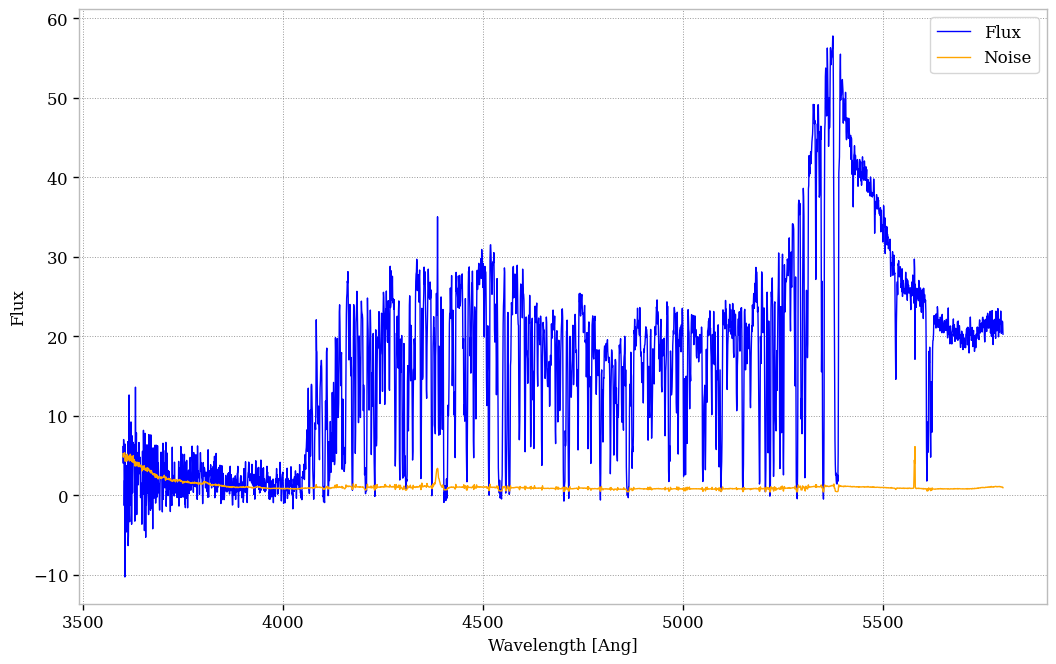

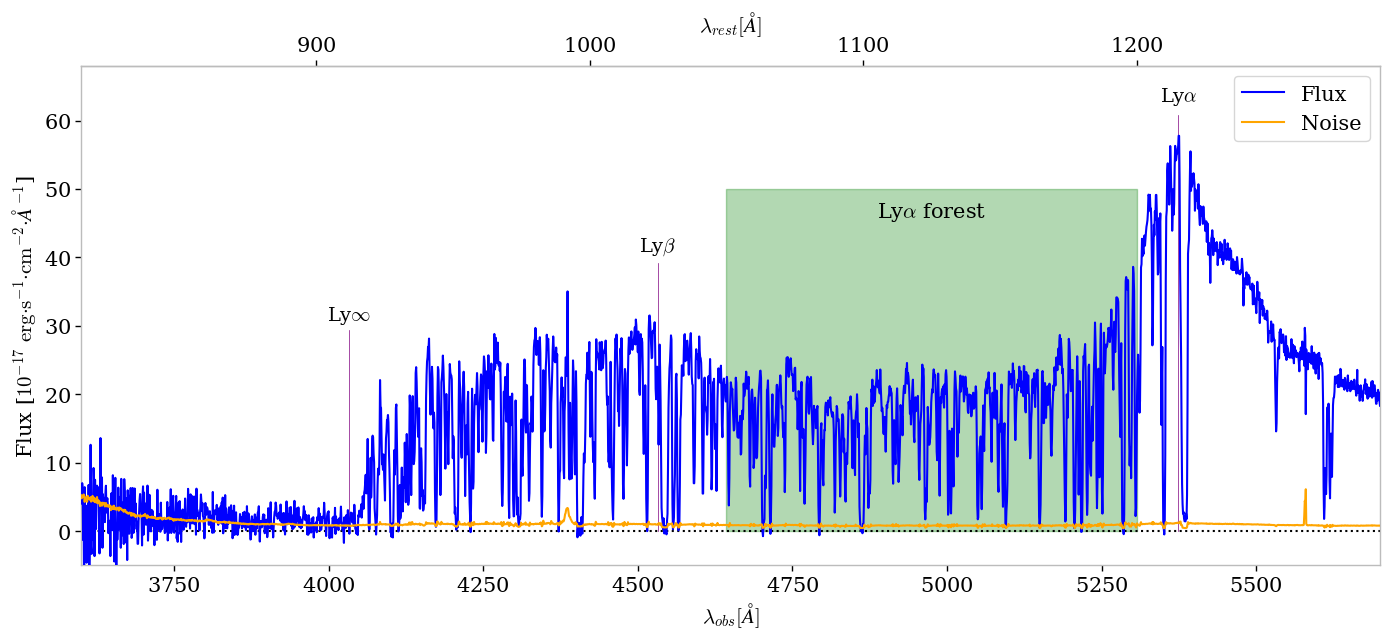

In [ ]:
# Plot the spectrum and its associated noise


plt.plot(wavelength,flux,lw=1,zorder=5,color='C0')
plt.plot(wavelength,1/np.sqrt(ivar),lw=1,zorder=5,color='C1')
plt.legend(["Flux","Noise"])
plt.xlabel("Wavelength [Ang]")
plt.ylabel("Flux")




# Bonus: add lines and range

figsize=(14,6.5)
ylabel = 'Flux ' + '[' + r'$10^{-17}~\mathrm{erg}$' + '$\cdot$' + r'$\mathrm{s}^{-1}$' + '$\cdot$' + r'$\mathrm{cm}^{-2}$' + '$\cdot$' + r'$\AA^{-1}$' + ']'
size = 15
size_line = 14
size_text = 15
line_width=1.5

fig = plt.figure(figsize=figsize)
ax = [plt.gca()]

ax[0].set_xlim(left=np.min(wavelength),right=5700)

ax[0].plot(wavelength,flux,lw=line_width,zorder=5,color='C0')
ax[0].plot(wavelength,1/np.sqrt(ivar),lw=line_width,zorder=5,color='C1')

ax[0].fill_betweenx([0,50],1050*(1+redshift_quasar),1200*(1+redshift_quasar),color='C2',alpha=0.3)

ax[0].text(1125*(1+redshift_quasar),45,r'Ly$\alpha$ forest',color='k',horizontalalignment='center',verticalalignment='bottom',size =size_text)

names = [r'Ly$\infty$',r'Ly$\beta$',r'Ly$\alpha$']
lines = [912, 1025, 1215.24]
heights = [30,40,62,30,30,25]


for i in range(len(lines)):
    ax[0].text(lines[i]*(1+redshift_quasar),heights[i],names[i],color='k',horizontalalignment='center',verticalalignment='bottom',size =size_line)
    ax[0].plot([lines[i]*(1+redshift_quasar),lines[i]*(1+redshift_quasar)],[0,0.98*heights[i]],color='purple',ls="-",lw=0.5)


ax[0].set_ylim(bottom=-5,top=68)
axtop=ax[0].secondary_xaxis('top', functions=(lambda lobs: lobs/(1+redshift_quasar), lambda lrest: lrest*(1+redshift_quasar)))
axtop.set_xlim(ax[0].get_xlim())
axtop.set_xlabel(r'$\lambda_{rest} [\AA]$', fontsize=size)
axtop.tick_params(axis='x', labelsize=size)

ax[0].margins(x=0)
ax[0].set_ylabel(ylabel, fontsize=size)
ax[0].tick_params(axis='y', labelsize=size)
ax[0].legend(["Flux","Noise"],fontsize=size)
ax[0].set_xlabel(r'$\lambda_{obs} [\AA]$', fontsize=size)
ax[0].tick_params(axis='x', labelsize=size)

ax[0].grid()
plt.axhline(0, ls=':', c='k')
fig.tight_layout()




What you just plotted is the spectrum of the quasar. In the Lyman-alpha forest, we are interested in the absorptions in the forest region. However, we need to account for the shape of the quasar spectrum if there was no absorption: we call that the **quasar continuum**

The first step in Lyman-alpha studies is to compute the flux (or Lyman-alpha) contrast:

$\delta_{F}(\lambda) = \frac{F(\lambda)}{\overline{F}(\lambda)} - 1 =   \frac{f(\lambda)}{C_{\mathrm{q}}(\lambda)\overline{F}(\lambda)} - 1$

Here, $F$ is the fraction of transmitted flux (with $\overline{F}$ its average value at a given point of the Universe), $C_{\mathrm{q}}$ the continuum of the quasar we consider, and $f$ the spectrum you have just plotted.

In most Lyman-alpha studies, we directly fit the product $C_{\mathrm{q}}(\lambda)\overline{F}(\lambda)$.

The continuum fitting step is very complicated. We need to use a dedicated software called [picca](https://github.com/igmhub/picca).

Here I am loading for you the results for the quasar we just plotted the spectra (wavelength_delta $\lambda$, continuum_product $C_{\mathrm{q}}\overline{F}$, delta $\delta$)


In [ ]:
delta_file = fitsio.FITS(os.path.join(path_to_data,"delta-387.fits.gz"))
wavelength_delta = delta_file[targeid_quasar]["LAMBDA"][:]
continuum_product = delta_file[targeid_quasar]["CONT"][:]
delta = delta_file[targeid_quasar]["DELTA_BLIND"][:]

---
**Your turn**

---

Plot the spectrum of the quasar with the fitted continuum product.

Hint: the wavelength array of the spectra (flux) and the continuum (continuum_product) are not the same

(4440.0, 5400.0)

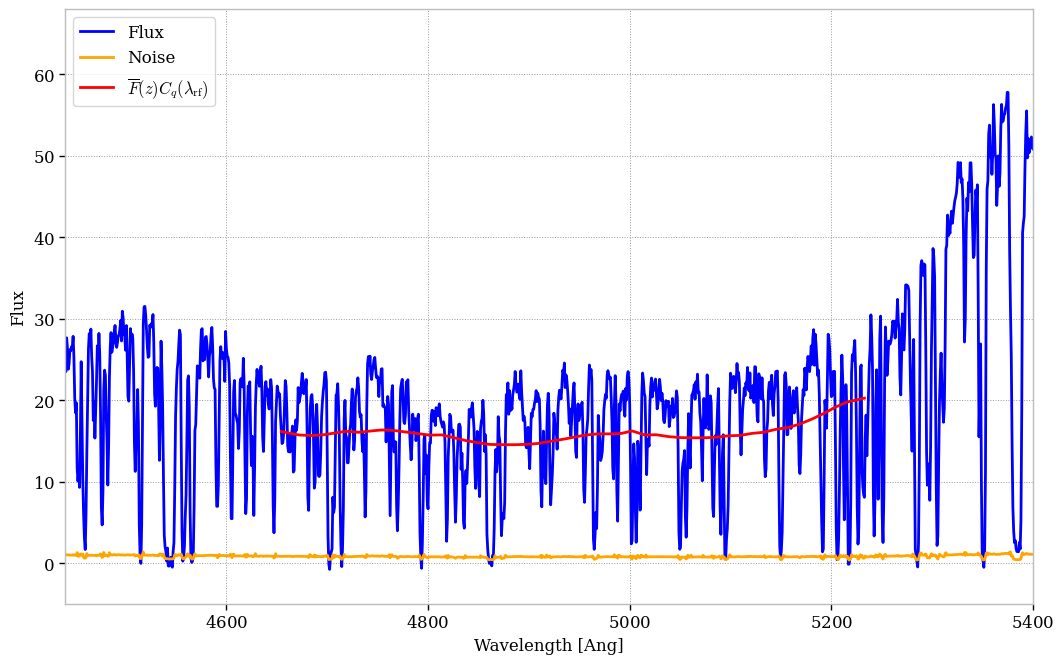

In [ ]:
# Plot the spectrum and its associated noise


plt.plot(wavelength,flux,lw=2,color='C0',label='Flux')
plt.plot(wavelength,1/np.sqrt(ivar),lw=2,color='C1',label='Noise')

plt.plot(wavelength_delta,continuum_product,color='C3',label=r'$\overline{F}(z)C_{q}(\lambda_{\mathrm{rf}})$',linewidth=2)

plt.legend()
plt.xlabel("Wavelength [Ang]")
plt.ylabel("Flux")

plt.ylim(bottom=-5,top=68)
plt.xlim(4440,5400)



The average transmitted flux fraction $\overline{F}$ can be computed theoretically. The formula is given by;

$\overline{F} = \exp(-\tau_{\mathrm{eff}})\, ,$

where $\tau_{\mathrm{eff}}$ is given by an empirical formula:

$\tau_{\mathrm{eff}} = A(1+z)^B + C \exp\left( \frac{-(1+z-D)^2}{(2E^2)}\right)$

I give you what you need next here:

In [ ]:
A = 0.0023
B = 3.64
C = -0.05
D = 4.36
E = 0.21
wavelength_lyman_alpha = 1215.67

---
**Your turn**

---

Try to compute $\overline{F}$ and to plot the continuum of the quasar.

Hint: z is the redshift of the absorber, not the quasar. The formula for the redshift is:

$1 + z = \frac{\lambda_{\mathrm{observed}}}{\lambda_{\mathrm{emitted}}}$



(4440.0, 5400.0)

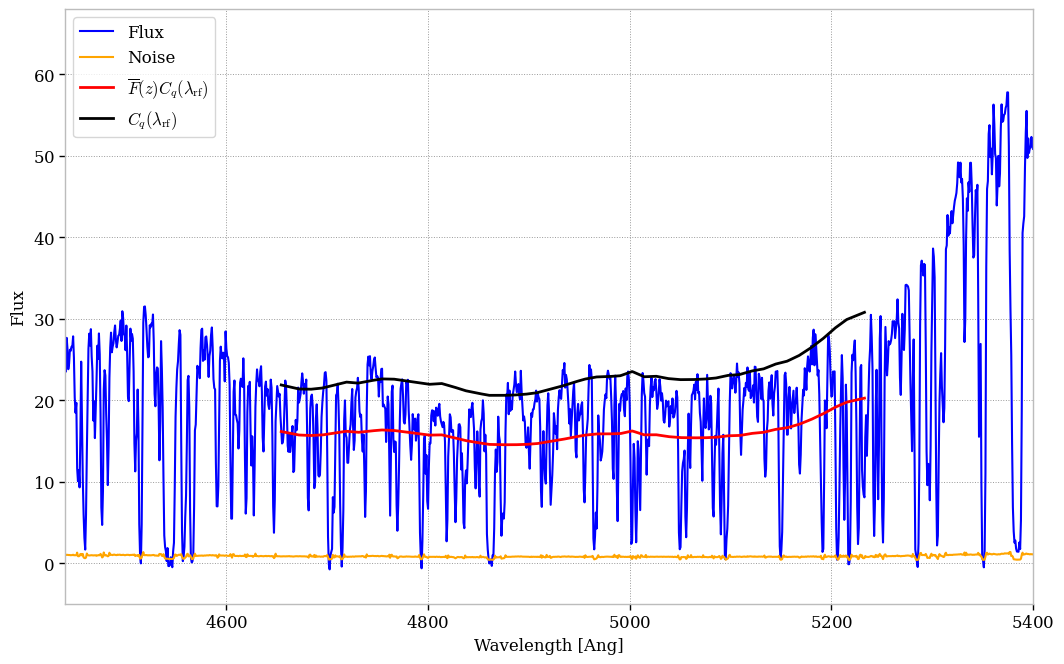

In [ ]:
# Plot the quasar continuum
z = (wavelength_delta/wavelength_lyman_alpha) - 1
teff = A*(1+z)**B + C*np.exp(-(1+z-D)**2/(2*E**2))
F_bar = np.exp(-teff)


plt.plot(wavelength,flux,lw=line_width,color='C0',label='Flux')
plt.plot(wavelength,1/np.sqrt(ivar),lw=line_width,color='C1',label='Noise')

plt.plot(wavelength_delta,continuum_product,color='C3',label=r'$\overline{F}(z)C_{q}(\lambda_{\mathrm{rf}})$',linewidth=2)
plt.plot(wavelength_delta,continuum_product/F_bar,color='k',label=r'$C_{q}(\lambda_{\mathrm{rf}})$',linewidth=2)

plt.legend()
plt.xlabel("Wavelength [Ang]")
plt.ylabel("Flux")

plt.ylim(bottom=-5,top=68)
plt.xlim(4440,5400)



---
**Your turn**

---

Finally, plot the flux contrast ($\delta$) as a function of wavelength just to visualize it

Text(0, 0.5, 'Delta')

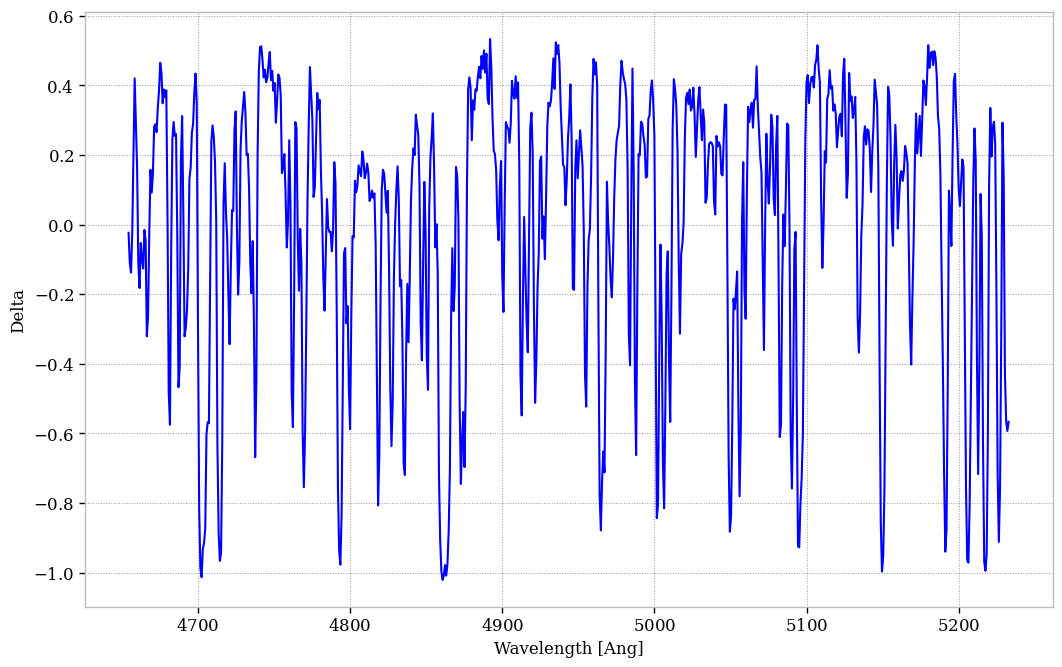

In [ ]:
# Plot delta


plt.plot(wavelength_delta,delta,lw=line_width,color='C0')

plt.xlabel("Wavelength [Ang]")
plt.ylabel("Delta")


## 4. FFT calculation (35 min):

Now that we have the normalized absorption, we want to compute the one-dimensional power spectrum (P1D).

P1D is the average of all the flux contrast in Fourier space. If you are unfamiliar with Fourier space, check [this link](https://en.wikipedia.org/wiki/Fourier_transform).


In order to compute P1D, we first need to compute the raw power spectrum for all the quasars we have. The raw power spectrum is theoretically defined by:


$(2\pi) \delta_{\mathrm{D}}(k-k') P_{\mathrm{raw}}(k) = \delta_F(k) \delta_F(k')$

Or, in a more simplified but less mathematical way:

$P_{\mathrm{raw}}(k) = |\delta_F(k)|^2$

Where || is the modulus (and $\delta_F(k)$ is a complex number)

And P1D is the average of all $P_{\mathrm{raw}}$ quasars:

$P_{1\mathrm{D}} = \langle | \delta_F(k)| ^2 \rangle_{q} = \langle P_{\mathrm{raw}}(k) \rangle_{q}$

We will start by calculating the raw power spectrum for one quasar. For that, we will use the Fast Fourier Transform method (FFT).

In [ ]:
delta_file = fitsio.FITS(os.path.join(path_to_data,"delta-387.fits.gz"))
wavelength_delta = delta_file[targeid_quasar]["LAMBDA"][:]
delta = delta_file[targeid_quasar]["DELTA_BLIND"][:]

---
**Your turn**

---

Compute $\delta_F(k)$ (i.e. in Fourier space) and $P_{\mathrm{raw}}(k)$ for one quasar. Also, compute the associated wavenumber array (k).

Hint: I give you the separation between two spectrum pixels (delta_lambda). Use the numpy.fft functions rfft and rfftfreq (already loaded, google highly recommended here).

In [ ]:
delta_lambda = 0.8

In [ ]:
# Compute the raw power spectrum.

length_lambda = delta_lambda * len(delta)
num_pixels = len(delta)

delta_fourier = rfft(delta)
raw_power = (delta_fourier.real**2 + delta_fourier.imag**2) * length_lambda / num_pixels**2

# Or equivalently:
# raw_power = np.absolute(delta_fourier)**2 * length_lambda / num_pixels**2

wavenumber = 2 * np.pi * rfftfreq(num_pixels, length_lambda / num_pixels)

---
**Your turn**

---

Plot the raw power spectrum as a function of wavenumber.


Text(0, 0.5, 'Raw power spectrum [Ang]')

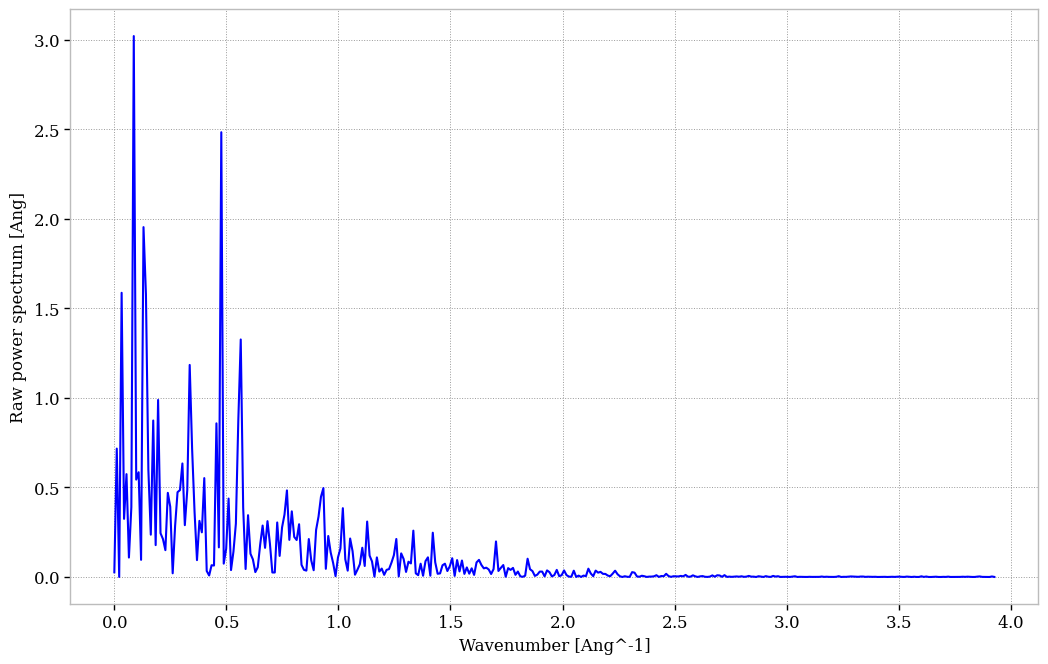

In [ ]:
# Plot the raw power spectrum.

plt.plot(wavenumber,raw_power)

plt.xlabel("Wavenumber [Ang^-1]")
plt.ylabel("Raw power spectrum [Ang]")


It is hard to interpret. This signal is the amplitude of variations/fluctuations in the Lyman-alpha forest of the quasar you have plotted previously.

The amplitude of variations/fluctuations depends on the scale considered. In Fourier space, low wavenumber corresponds to large scales, and large wavenumber to small scales.

We are interested in the variation of amplitudes as a function of redshift. For the forest we just computed, the average redshift of absorption is:


In [ ]:
redshift_raw_power = delta_file[targeid_quasar].read_header()["MEANZ"]

Now we will try to compute the P1D (average of raw power spectra) for a range of redshift (let's say between 2.1 and 2.5) with several quasars.

---
**Your turn**

---

First, select the Lyman-alpha forest whose average redshift is between 2.1 and 2.5

In [ ]:
# Loop over the delta_file and select the ones that suit

deltas = []

for i in range(1,len(delta_file)):
  redshift_raw_power = delta_file[i].read_header()["MEANZ"]
  if (redshift_raw_power > 2.1)&(redshift_raw_power < 2.5):
    deltas.append(delta_file[i]["DELTA_BLIND"][:])


---
**Your turn**

---

For all the selected delta, compute the raw power spectrum and the wavenumber

In [ ]:
# Loop over the deltas and compute raw power spectra

delta_lambda = 0.8
raw_powers = []
wavenumbers = []


for i in range(len(deltas)):
  num_pixels = len(deltas[i])
  length_lambda = delta_lambda * len(deltas[i])
  delta_fourier = rfft(deltas[i])
  raw_powers.append((delta_fourier.real**2 + delta_fourier.imag**2) * length_lambda / num_pixels**2)
  wavenumbers.append(2 * np.pi * rfftfreq(num_pixels, length_lambda / num_pixels))


We have flux contrasts with different lengths. We need to create a common wavenumber array to compute our P1D and then fill the average array in agreement with this average wavenumber array.

In [ ]:
k_min = 0.045
k_max = 2.0
number_edge_bins = 31

common_wavenumber_egdes = np.linspace(k_min, k_max, number_edge_bins)
common_wavenumber_centers = (common_wavenumber_egdes[1:] + common_wavenumber_egdes[:-1]) / 2

---
**Your turn**

---

Fill a P1D array with the same size as the common wavenumber array (common_wavenumber_centers). For each wavenumber bin i, compute the average of raw power spectra for the wavenumber between common_wavenumber_egdes[i] and common_wavenumber_egdes[i+1].

Hint: You can use numpy masks to speed up the process.

In [ ]:
# Compute p1d for the selected deltas

p1d = []

for i in range(len(common_wavenumber_centers)):
  p1d_k = []
  k_range_min = common_wavenumber_egdes[i]
  k_range_max = common_wavenumber_egdes[i+1]
  for j in range(len(raw_powers)):
    mask_wavenumber = (wavenumbers[j] >= k_range_min) & (wavenumbers[j] < k_range_max)
    p1d_k.append(raw_powers[j][mask_wavenumber])
  p1d_k = np.concatenate(p1d_k)
  p1d.append(np.mean(p1d_k))


---
**Your turn**

---

Plot the P1D as a function of the common wavenumber array (common_wavenumber_centers). You can plot the normalized P1D (no units):

$\Delta_{1\mathrm{D}}(k) = k P_{1\mathrm{D}}(k)/\pi$

Text(0.5, 0, 'Wavenumber [Ang^-1]')

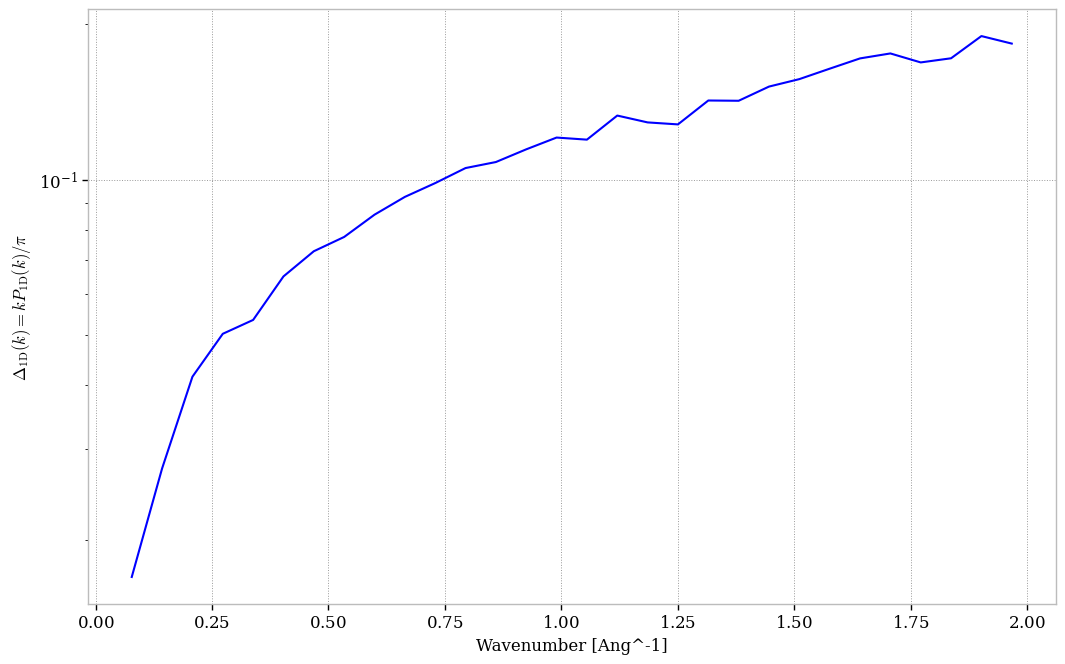

In [ ]:
# Plot P1D

plt.semilogy(common_wavenumber_centers, common_wavenumber_centers * p1d /np.pi)

plt.ylabel(r"$\Delta_{1\mathrm{D}}(k) = k P_{1\mathrm{D}}(k)/\pi$")
plt.xlabel(r"Wavenumber [Ang^-1]")

If you properly followed the steps, you have a signal with a few quasars. You can already see an oscillation at small wavenumber (large scales), corresponding to metals (Si) blended with Lyman-alpha.


Here, you have computed the P1D from the raw power spectrum. This raw power spectrum contains the Lyman-alpha absorption signal and all the other contaminant effects that impact the forest (noise, spectrograph resolution, metals, masking, etc.). We need to correct for all those impacts if we want a proper P1D measurement.


The project associated to this tutorial aims to do this proper computation, starting from all the available spectra of DESI.